## Generate a table of avg region values for our master region list and all TCGA files of interest

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import pickle
#from core.gcloud.file import opener

import seaborn as sns
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
from collections import defaultdict
# load probe metadata
probe_metadata = pickle.load(open("../df_keep_probes_metadata.pkl", "rb"))
probe_metadata

# make probe metadata into a dict by chrm
probe_dict = defaultdict(list)
for i, row in probe_metadata.iterrows():
    probe_dict[row.Chromosome].append((i, int(row.Start), int(row.End)))

In [4]:
# collate stats per region

def calc_region_averages(df_clean_regions, df_tcga_probes, probe_dict, title):
    global region_stats
    region_stats = {}
    i=0
    region_avs_list = []
    region_names = []
    # for region in infile:
    for i,region in df_clean_regions.iterrows():
        #print(region)
        if i % 100 == 0:
            print(i)
        # determine which probes are in the region
        probes = []
        for name, start, stop in probe_dict[region.chrom]:
            if int(start) >= int(region.start) and int(stop) <= int(region.end):
                if name in df_tcga_probes.index:
                    probes.append(name)
        #print(probes)
        if len(probes)>0:
            region_names.append(region.real_name)
            df_tcga_subset = df_tcga_probes.loc[probes,:]
            sample_averages = df_tcga_subset.mean(axis=0, skipna=True)

            region_avs_list.append(sample_averages)

            sample_stdvs = df_tcga_subset.std(axis=0, skipna=True)
            pct_samples_meth = sum([m >= 0.2 for m in sample_averages])/len(df_tcga_subset)
            mean_sample_stdv = np.mean(sample_stdvs)

            region_stats[region.real_name] = {"pct_samples_meth":pct_samples_meth,
                                        "mean_sample_stdv": mean_sample_stdv,
                                    "sample_average_beta": np.mean(sample_averages)}
            i += 1
        else:
            continue
    
    # compile each list of region averages per sample into a matrix for heatmap
    global df_region_avs
    df_region_avs = pd.DataFrame(region_avs_list) #regions by samples
    df_region_avs.colunns = df_tcga_probes.columns
    df_region_avs.index = region_names
    

    df_region_avs = df_region_avs.fillna(0)
    df_region_avs.head()

    with open(f"./{title}.csv","w") as fout:
        df_region_avs.to_csv(fout)
        
    with open(f"./{title}_region_summary_stats.pkl","w") as fout:
        region_dict = pd.DataFrame(region_stats)
        region_dict.to_csv(fout, index=None)
    
    print("Complete") 
    return df_region_avs, region_stats

In [4]:
# read in master regions file
with open("../biomarker_lock_june_2020_hmf_regions_merged_1phealthy_metilene.source_annotated_formatted.bed","r") as fin:
    df_master_regions = pd.read_csv(fin, sep="\t", header=None)
    
df_master_regions.columns = ["chrom","start","end"]
df_master_regions["real_name"] = df_master_regions["chrom"]+":"+df_master_regions["start"].astype(str)+":"+df_master_regions["end"].astype(str)
df_master_regions.head()

,chrom,start,end,real_name
0,chr1,827683,827862,chr1:827683:827862
1,chr1,905064,905611,chr1:905064:905611
2,chr1,925421,925756,chr1:925421:925756
3,chr1,1059023,1059377,chr1:1059023:1059377
4,chr1,1115135,1115467,chr1:1115135:1115467


In [5]:
df_tcga_prad = pickle.load(open("./cancers/df_edu_PRAD_raw_beta_vals.pkl","rb"))
df_tcga_prad.head()

,TCGA-HC-8261-01A-11D-2261-05,TCGA-EJ-7115-01A-11D-2116-05,TCGA-J4-AATZ-01A-11D-A41L-05,TCGA-HC-A6AO-01A-11D-A30F-05,TCGA-EJ-A65J-01A-11D-A30Z-05,TCGA-EJ-7793-01A-31D-2261-05,TCGA-EJ-5525-01A-01D-1578-05,TCGA-YL-A9WJ-01A-11D-A378-05,TCGA-EJ-5495-01A-01D-1578-05,TCGA-Y6-A9XI-01A-11D-A41L-05,...,TCGA-KK-A8IG-01A-11D-A365-05,TCGA-EJ-AB27-01A-11D-A41L-05,TCGA-QU-A6IN-01A-11D-A31M-05,TCGA-XK-AAIV-01A-11D-A41L-05,TCGA-H9-7775-01A-11D-2116-05,TCGA-HC-8260-01A-11D-2261-05,TCGA-XA-A8JR-01A-11D-A365-05,TCGA-KK-A8IC-01A-11D-A365-05,TCGA-FC-A8O0-01A-41D-A378-05,TCGA-2A-AAYF-01A-11D-A41L-05
Composite Element REF,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.141956,0.096125,0.094730,0.077482,0.130052,0.072944,0.103477,0.136103,0.159618,0.115961,...,0.156025,0.129518,0.080481,0.271380,0.084727,0.073851,0.090207,0.103546,0.069792,0.099066
cg00000108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cg00000109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cg00000165,0.322637,0.132029,0.290843,0.058730,0.064343,0.334680,0.796171,0.101514,0.400473,0.307059,...,0.092473,0.152170,0.859213,0.359398,0.895153,0.339325,0.328953,0.351800,0.112109,0.071260
cg00000236,0.904383,0.906728,0.865136,0.913134,0.922121,0.882514,0.869580,0.818961,0.865578,0.853857,...,0.886381,0.887879,0.885753,0.859026,0.936362,0.916845,0.874217,0.875007,0.874211,0.894560


In [ ]:
df_prad, prad_region_dict = calc_region_averages(df_master_regions, df_tcga_prad, probe_dict, "PRAD_master_region_averages")

In [6]:
# load Rui's clean in healthy plasma regions
#!gsutil cp gs://reference-datafiles/freenome_panels/biomarker_lock_june_2020/roughly_clean_in_healthy_max_hmf_0.005.bed .
#!head roughly_clean_in_healthy_max_hmf_0.005.bed

df_clean_reg = pd.read_csv(open("./roughly_clean_in_healthy_max_hmf_0.005.bed", "r"), sep="\t", header=None)

df_clean_reg.columns = ["chrom","start","end"]
df_clean_reg["real_name"] = df_clean_reg["chrom"] + ":" + df_clean_reg["start"].astype(str) + ":" +df_clean_reg["end"].astype(str)

df_clean_reg.iloc[:,2] = df_clean_reg.iloc[:,2].astype(int)
df_clean_reg.iloc[:,1] = df_clean_reg.iloc[:,1].astype(int)

df_clean_reg.head()

,chrom,start,end,real_name
0,chr1,827037,827904,chr1:827037:827904
1,chr1,1324214,1325305,chr1:1324214:1325305
2,chr1,2545946,2547720,chr1:2545946:2547720
3,chr1,3899793,3901520,chr1:3899793:3901520
4,chr1,6198771,6199823,chr1:6198771:6199823


In [8]:
df_met_reg = pd.read_csv(open("./meteline_clean_in_healthy_merged.bed", "r"), sep="\t", header=None)

df_met_reg.columns = ["chrom","start","end"]
df_met_reg["real_name"] = df_met_reg["chrom"] + ":" + df_met_reg["start"].astype(str) + ":" +df_met_reg["end"].astype(str)

df_met_reg.iloc[:,2] = df_met_reg.iloc[:,2].astype(int)
df_met_reg.iloc[:,1] = df_met_reg.iloc[:,1].astype(int)

df_met_reg.head()

,chrom,start,end,real_name
0,chr1,1427560,1427904,chr1:1427560:1427904
1,chr1,3068460,3069278,chr1:3068460:3069278
2,chr1,3070602,3070974,chr1:3070602:3070974
3,chr1,4653898,4654475,chr1:4653898:4654475
4,chr1,4654485,4656643,chr1:4654485:4656643


In [9]:
df_prad, prad_region_dict = calc_region_averages(df_met_reg, df_tcga_prad, probe_dict, "PRAD_met_region_averages")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2800
2900
3000
3100
3200
3300
3400


/home/billiegould/.virtualenvs/pineapple-env/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


Complete


/home/billiegould/.virtualenvs/pineapple-env/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 0.98, 'TCGA PRAD potential biomarkers')

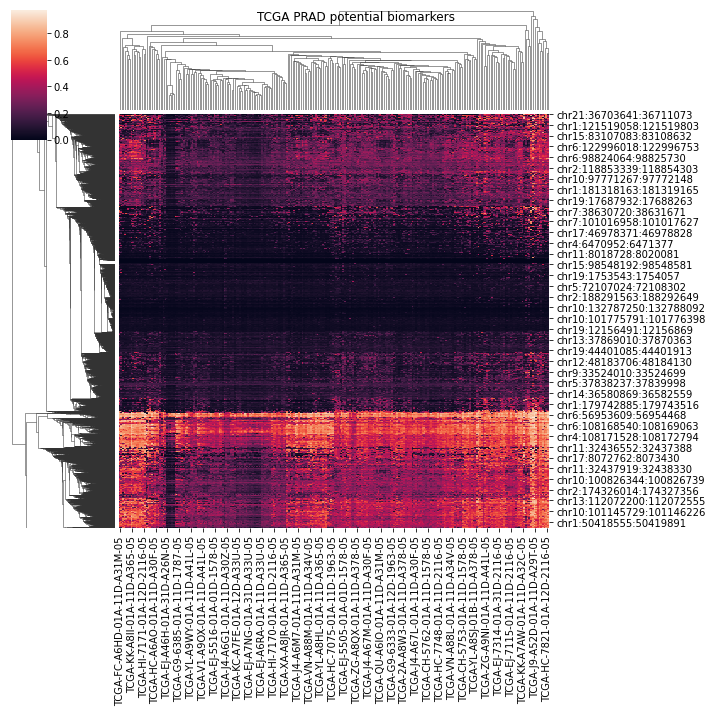

In [10]:
p = sns.clustermap((df_prad),
                  col_cluster=True)
p.fig.suptitle("TCGA PRAD potential biomarkers")

In [13]:
def make_bed(region_stats_dict, cancer):
#     df_region_stats = pd.DataFrame(region_stats_dict)
#     df_region_stats_pass = df_region_stats[df_region_stats["sample_average_beta"]>0.2]
#     df_region_stats_pass = df_region_stats_pass.sort_values("sample_average_beta", ascending=False)
#     df_region_stats_pass["real_name"].str.split(":", expand=True)
#     print(df_region_stats_pass.head())

    with open(f"./{cancer}_potential_methyl_marker_regions.bed","w") as fout:
        for key, val in region_stats_dict.items():
            chrom = key.split(":")[0]
            start = key.split(":")[1]
            end = key.split(":")[2]
            pct_samples_meth = val["pct_samples_meth"]
            sample_avg_beta = val["sample_average_beta"]
            if sample_avg_beta >  0.2 and pct_samples_meth >= 0.5:
                fout.write(("\t").join([chrom, str(start), str(end), str(pct_samples_meth), str(sample_avg_beta), "\n"]))
            
    with open(f"./{cancer}_all_clean_region_scores.bed","w") as fout:
        for key, val in region_stats_dict.items():
            chrom = key.split(":")[0]
            start = key.split(":")[1]
            end = key.split(":")[2]
            pct_samples_meth = val["pct_samples_meth"]
            sample_avg_beta = val["sample_average_beta"]
            fout.write(("\t").join([chrom, str(start), str(end), str(pct_samples_meth), str(sample_avg_beta), "\n"]))

In [14]:
make_bed(prad_region_dict, "PRAD")